In [305]:
import pandas as pd
import numpy as np
import spacy
import os
import time
import gensim
import re
import nltk
import en_core_web_sm
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [107]:
nlp = en_core_web_sm.load()

In [126]:
df = pd.read_csv("final_data.csv",index_col=False)

In [127]:
df["Review"].isna().sum()

1

In [128]:
df = df.dropna().reset_index(drop=True)

In [129]:
skills = [line.strip() for line in open("intermediate.txt", 'r')]

In [130]:
df.head(70)

,Category,Review,Rating
0,Data Engineer,data tech cprogramminglanguage api machinelear...,1
1,Data Engineer,data tech manage managementexperience microsof...,1
2,Data Engineer,googleapi data lean center api shell services ...,1
3,Data Engineer,data flow elastic analysis python eve start an...,4
4,Data Engineer,data you microsoft python and desktop desk exp...,2
...,...,...,...
65,Data Science,data analysis python and predictiveanalytics e...,2
66,Data Science,data analysis python biology and predictiveana...,4
67,Data Science,data client statistics keras word analysis pyt...,5
68,Data Science,data medical statistics health you video graph...,5


In [132]:
corpus = []
count = 0
for i in range(len(df)):
    review = nltk.word_tokenize(df["Review"][i])
    review = [word for word in review if not word in (set(stopwords.words('english')),set(skills))]
    review = ' '.join(review)
    if count == 0 :
        print(review)
        count += 1
    corpus.append(review)


data tech cprogramminglanguage api machinelearning apache sql end python eve spark business software computersoftware softwareengineering apipython and asis coop skills computer programming experience dprogramminglanguage forpython record businessintelligence rprogramminglanguage technology learn analytics bigdata engineering program dataanalytics pythonsql medicaldevice mis education pyfor public scala machine businessreengineering per pythonx lan


In [133]:
corpus_bkp = corpus.copy()

In [204]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=100)
X = cv.fit_transform(corpus).toarray()

In [206]:
df1 = pd.DataFrame(X, columns=cv.get_feature_names())

In [207]:
df2 = pd.get_dummies(df, columns=['Category'],drop_first=True)

In [208]:
df_data = df1.append(df2, ignore_index=True)

In [211]:
df_data= pd.concat((df1, df2), axis=1)

In [212]:
df_data.shape

(1074, 127)

In [213]:
df_data = df_data.drop(['Review'], axis = 1)

In [214]:
X = df_data.drop(['Rating'], axis = 1)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [216]:
from sklearn.model_selection import train_test_split
x_train_sm, X_test, y_train_sm, y_test = train_test_split(X, df_data["Rating"], test_size=0.2, random_state=0)

In [217]:
X_train, X_cv, y_train, y_cv = train_test_split(x_train_sm, y_train_sm, test_size=0.2, random_state=0)

# Base Model - Naive Bayes 

In [220]:
from sklearn.naive_bayes import MultinomialNB

In [221]:
classifier=MultinomialNB(alpha=0.1)

In [222]:
from sklearn import metrics
import itertools

In [223]:
previous_score=0
for alpha in np.arange(0,1,0.1):
    sub_classifier=MultinomialNB(alpha=alpha)
    sub_classifier.fit(X_train,y_train)
    y_pred=sub_classifier.predict(X_cv)
    score = metrics.accuracy_score(y_cv, y_pred)
    if score>previous_score:
        classifier=sub_classifier
    print("Alpha: {}, Score : {}".format(alpha,score))

Alpha: 0.0, Score : 0.8313953488372093
Alpha: 0.1, Score : 0.8313953488372093
Alpha: 0.2, Score : 0.8313953488372093
Alpha: 0.30000000000000004, Score : 0.8255813953488372
Alpha: 0.4, Score : 0.8197674418604651
Alpha: 0.5, Score : 0.8197674418604651
Alpha: 0.6000000000000001, Score : 0.8197674418604651
Alpha: 0.7000000000000001, Score : 0.8197674418604651
Alpha: 0.8, Score : 0.8197674418604651
Alpha: 0.9, Score : 0.8197674418604651


C:\Users\Admin\AppData\Roaming\Python\Python39\Scripts\mypython\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


In [224]:
classifier=MultinomialNB(alpha=0.4)

accuracy:   0.805
Confusion matrix, without normalization


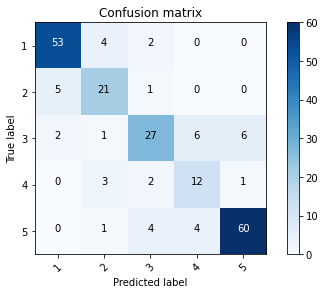

In [225]:
classifier.fit(x_train_sm, y_train_sm)
pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=[1,2,3,4,5])

# Training on Various models

In [306]:
cv = CountVectorizer(max_features=70)
X = cv.fit_transform(corpus).toarray()

df1 = pd.DataFrame(X, columns=cv.get_feature_names())
df2 = pd.get_dummies(df, columns=['Category'],drop_first=True)
df_data= pd.concat((df1, df2), axis=1)
df_data = df_data.drop(['Review'], axis = 1)
X = df_data.drop(['Rating'], axis = 1)

#x_train_sm, X_test, y_train_sm, y_test = train_test_split(X, df_data["Rating"], test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, df_data["Rating"], test_size=0.3, random_state=0)
trans = StandardScaler()
X_train=trans.fit_transform(X_train)
X_test=trans.fit_transform(X_test)


In [311]:

pipe = Pipeline([("classifier", RandomForestClassifier())])

grid_param = [
                {"classifier": [MultinomialNB()],
                 "classifier__alpha": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
                 },
                {"classifier": [LogisticRegression(n_jobs=1)],
                 "classifier__penalty": ['l1','l2'],
                 "classifier__C": [0.01,0.1,1,10,30,50,100],
                 "classifier__max_iter" : [1000]
                    },
                {"classifier": [SGDClassifier(random_state=42)],
                 "classifier__loss": ['hinge','modified_huber'],
                 "classifier__penalty" : ['l2','l1'],
                 "classifier__alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
                 },
                {"classifier": [RandomForestClassifier()],
                 "classifier__n_estimators": [10, 100, 1000],
                 "classifier__max_depth":[5,8,15,25,30,None],
                 "classifier__min_samples_leaf":[1,2,5,10,15,100],
                 "classifier__max_leaf_nodes": [2, 5,10]}]
# create a gridsearch of the pipeline, the fit the best model
gridsearch = GridSearchCV(pipe, grid_param, cv=5, verbose=0,n_jobs=-1) # Fit grid search
best_model = gridsearch.fit(X_train,y_train)


In [312]:
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X_test,y_test))

Pipeline(steps=[('classifier',
                 LogisticRegression(C=100, max_iter=1000, n_jobs=1))])
The mean accuracy of the model is: 0.9597523219814241


In [332]:
pred=best_model.predict(X_test)

In [327]:
print(best_model.cv_results_.keys())

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_classifier', 'param_classifier__alpha', 'param_classifier__C', 'param_classifier__max_iter', 'param_classifier__penalty', 'param_classifier__loss', 'param_classifier__max_depth', 'param_classifier__max_leaf_nodes', 'param_classifier__min_samples_leaf', 'param_classifier__n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])


Confusion matrix, without normalization


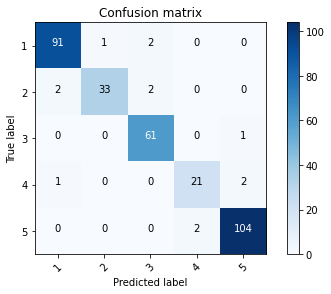

In [316]:
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=[1,2,3,4,5])


# Final Model Building

In [328]:
import pickle

In [330]:
filename = 'finalized_model.sav'
pickle.dump(best_model, open(filename, 'wb'))